
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Détection de race de chien à partir d'images grâce aux réseaux de neurones à convolution
        </h1>
    </div>
</div>

L'objectif de ce Notebook est de détailler la mise en place d'un algorithme de détection de la race du chien sur une photo.

Les contraintes  :

- Pré-processer les images avec des techniques spécifiques (e.g. whitening, equalization,  crop images).
- Réaliser de la data augmentation (mirroring, cropping...).
- Mise en oeuvre de 2 approches de l'utilisation des CNN :
- Réaliser un réseau de neurones CNN from scratch en optimisant les paramètres.
- Utiliser le transfert learning et utiliser un réseau déjà entrainé.


<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Sommaire
        </h1>
    </div>
</div>

- **[Visualisation du dataset](#vis)**

- **[Preprocessing : des images](#pre)**

- **[Developpement de notre propre réseau CNN](#cnn)**

- **[Definition de nos metriques](#me)**

- **[Transfert learning Xception](#xc)**

- **[Transfert learning avec ResNet50](#res)**

- **[Optimisation du modele Xception avec Kerastuner](#op)**

- **[Xception fine tuning](#fi)**

- **[Resultats](#resu)**


In [1]:
from google.colab import drive
drive.mount('/content/ShardDrives/', force_remount=True)

Mounted at /content/ShardDrives/


In [ ]:
!nvidia-smi

Tue Apr 12 15:29:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install keras-tuner

     |████████████████████████████████| 133 kB 11.8 MB/s 


In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgmp
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from tqdm import tqdm
import keras_tuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [4]:
print(tf.__version__)

2.8.0


In [4]:
# import utils own functions
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

test GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-04-14 14:08:02.150445: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 14:08:02.212994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:08:02.275150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:08:02.275325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<a name='vis'></a>


<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Visualisation du dataset
        </h1>
    </div>
</div>

In [6]:
!mkdir /content/Stanford_Dogs_Dataset/

In [8]:
!tar -xf /content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/annotation.tar --directory /content/Stanford_Dogs_Dataset/

In [9]:
!tar -xf /content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/images.tar --directory /content/Stanford_Dogs_Dataset/

In [11]:
annotations_directory = '/content/Stanford_Dogs_Dataset/Annotation' 
images_directory = '/content//Stanford_Dogs_Dataset/Images'
utils.rename_directory(images_directory,annotations_directory)

True

In [12]:
races_list = os.listdir(images_directory)
annotation_list = os.listdir(annotations_directory)

In [13]:
print("Nombre de race dans le dataset:", (len(races_list)))
nb_photos_pear_races = [len(os.listdir(images_directory + "/" + name))for name in races_list]

Nombre de race dans le dataset: 120


120 races de chien sont donc présentes dans notre jeu de données, ce qui représente 120 classes pour notre classifier.

In [15]:
df_races = pd.DataFrame(
    index=races_list,
    data=nb_photos_pear_races,
    columns=["nb_photos"])

In [ ]:
df_races.sample(5)

nb_photos
Doberman                           150
Welsh_springer_spaniel             150
flat-coated_retriever              152
redbone                            148
German_short-haired_pointer        152

In [ ]:
df_races.nb_photos.sum()

20580

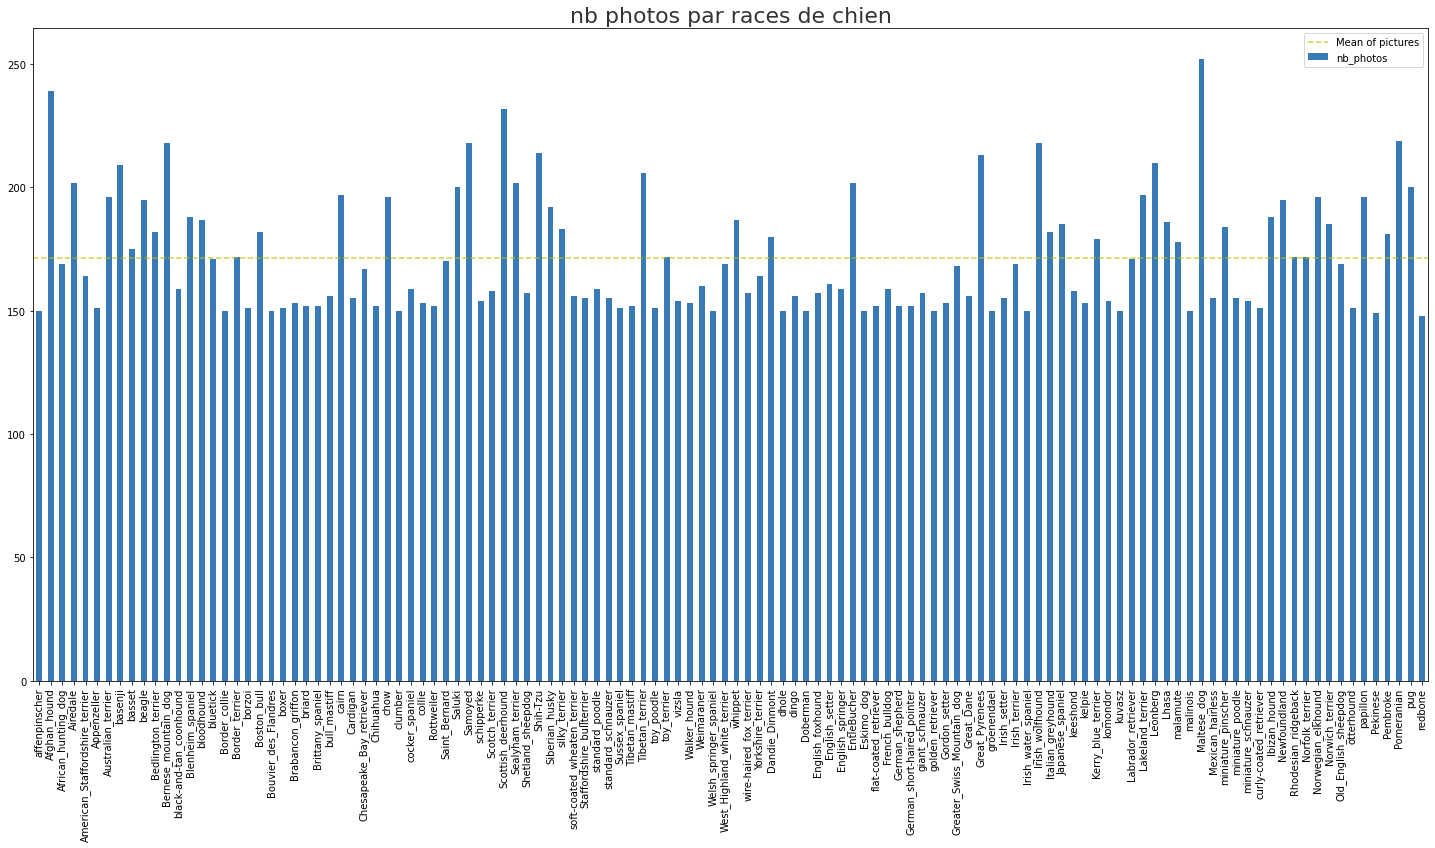

In [ ]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_races.plot(kind="bar",color='#377AB7',
               legend=False,
               ax=ax)
ax.axhline(df_races["nb_photos"].mean(),
           color='y', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("nb photos par races de chien",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [16]:
df_races["nb_photos"].mean()

171.5

On remarque que les races de chien sont toutes bien alimentées en images. 
La moyenne se situe à 171 photos par classe.
Aucune race n'est sous représentée 

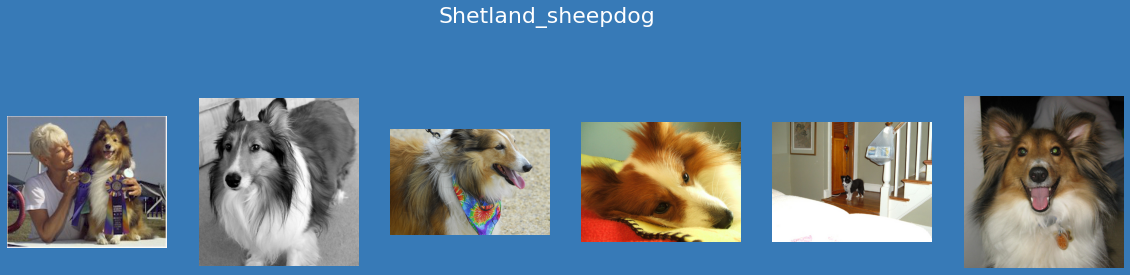

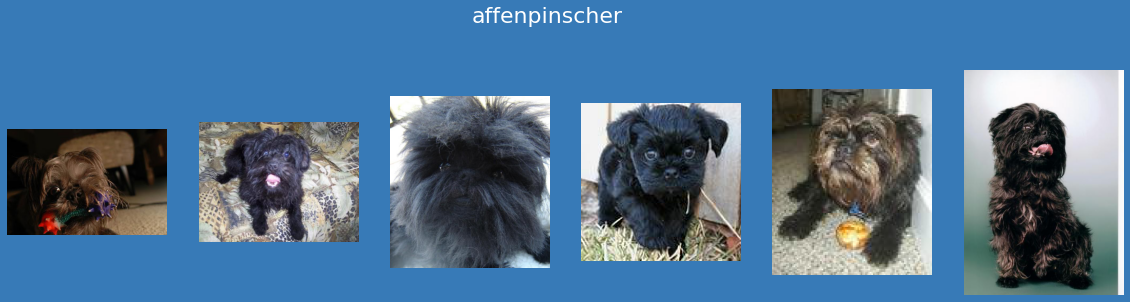

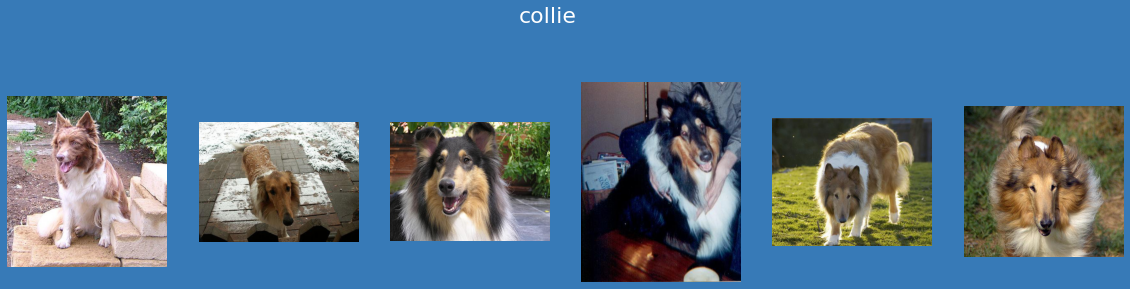

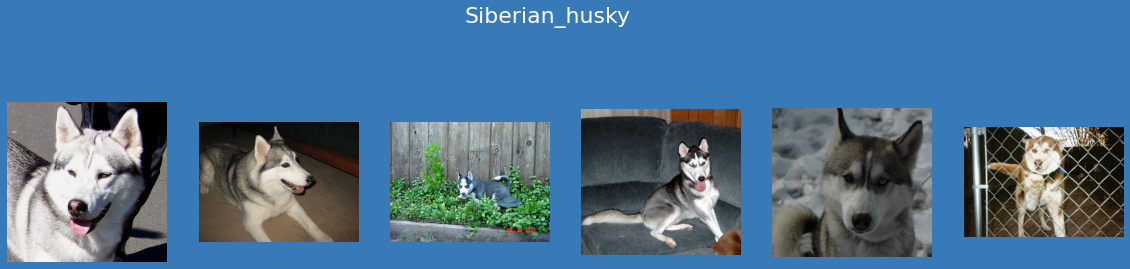

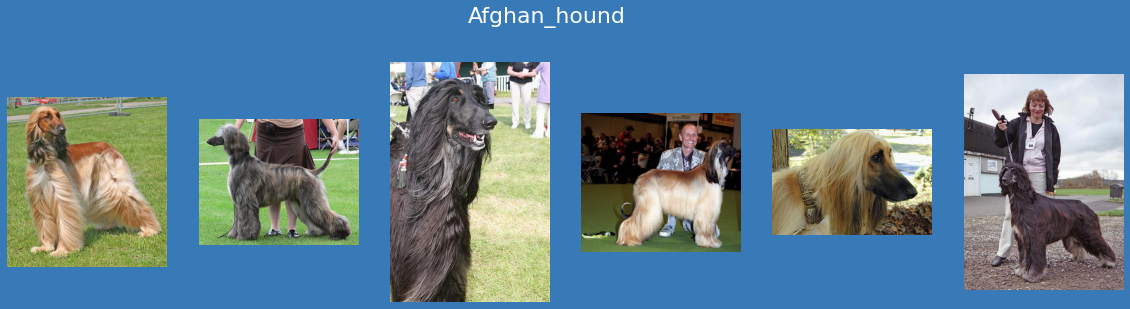

In [ ]:
for i in np.random.randint(0, len(races_list), size=5):
    utils.show_images_from_directory(images_directory, races_list[i], 6)

Nous allons devoir modifier la taille des images pour qu'elles s'adaptent aux contraintes du modèle CNN de transfert learning. Cela diminuera aussi les temps de calculs de notre modèle simple

Nous devons adapter la resolution des photos aux reseau convolutionel choisi ici Xception (resolution 299*299)

<a name='pre'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
          Preprocessing des images
        </h1>
    </div>
</div>

![image.png](attachment:image.png)

Dans ce projet nous devons utiliser une technique de transfert learning disponible a cette adresse 

https://keras.io/api/applications/.

En fonction du modele choisi , nous devrons pretraiter la taille des images du dataset.
Nous avons selectionner les modeles en fonction de leur **performance**, la **taille des images** (pour des raisons pratique), **profondeur du modele** acceptable pour ne pas surcharger nos temps de calcul

modeles choisis

- Xception ( 88 MB, Top-5 Accuracy à 0.945 ) 

- REsNet50 (98Mb	top 5 0.921%	 )




 * modification de la taille de nos images 
 
Les chiens présents sur les photos ne sont pas forcement au centre dans la photo,  les zooms sont différents. Redimensionner les images ne va pas changer ces attributs, l'image va même être déformée pour coller au nouvelles dimensions.

In [ ]:
# Define test image
test_img = (images_directory + "/American_Staffordshire_terrier/n02093428_443.jpg")
test_img = cv.imread(test_img)
dim = (299, 299)
res_img = cv.resize(test_img, dim, interpolation=cv.INTER_LINEAR)

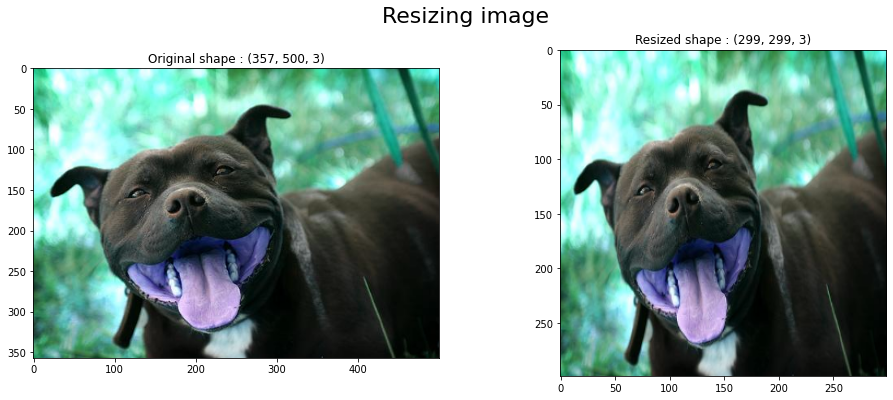

In [ ]:
# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Original shape : {}".format(test_img.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

On voit bien ici que le redimensionnement en 299 x 299 déforme la photo initiale.

Avec un set d'image relativement important, les expositions, contraste, ... sont relativement différents pour chaque photo. 

Nous allons à présent utiliser des méthodes basées sur les histogrammes de ces images pour pre-processer au mieux ces données.

# histogramme des images

- L'histogramme d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité.

Nous allons transformer l'image dans différents codages couleurs. 

Le système de codage YUV est créé depuis une source RVB. 
Il est codé en trois composantes : 
- Y représente la luminance (informations de luminosité) 
- tandis que les deux autres (U et V) sont des données de chrominance (informations de couleur). 

Ce format nous permet de visualiser au mieux l'histogramme pour les 3 dimensions

In [ ]:
img_RGB = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(test_img, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(test_img,cv.COLOR_BGR2YUV)

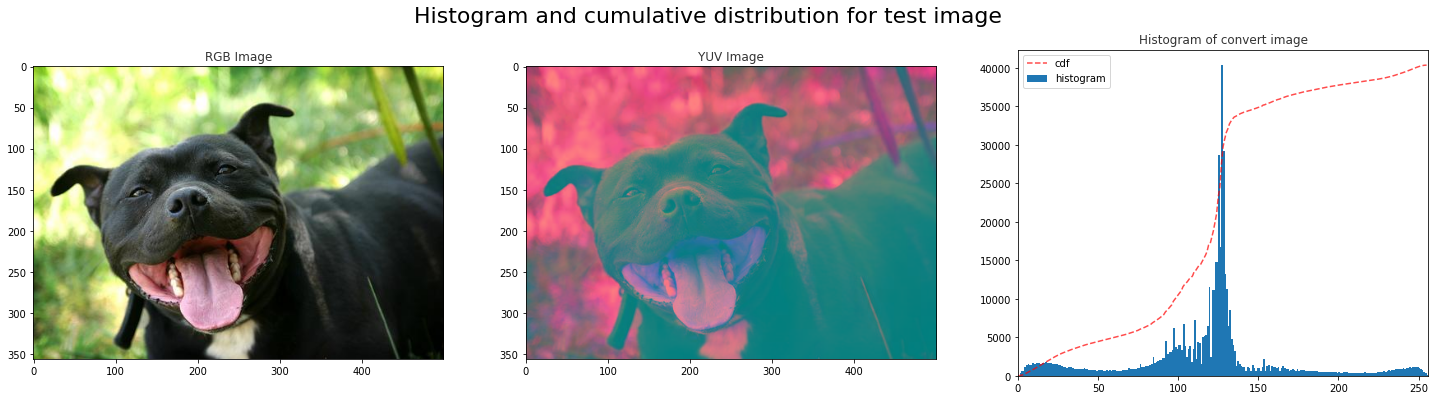

In [ ]:
utils.plot_histogram(["RGB", img_RGB], ["YUV", img_YUV] )

 ## Egalisation 
 
 Afin d eviter les pics de nos histogrammes nous allons utiliser l egalisation qui augmentera la lumière dans tout le spectre de l'image.
 

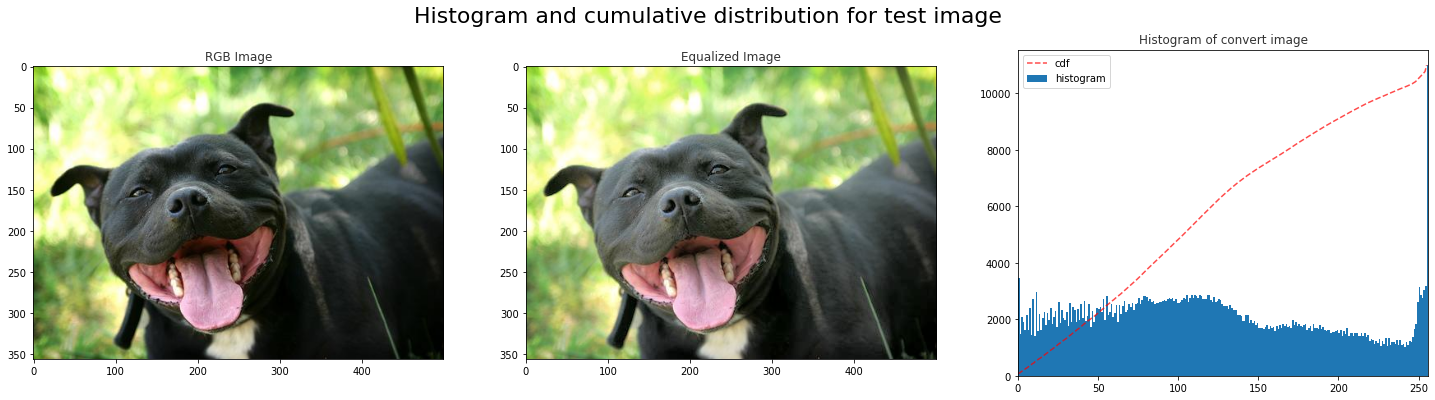

In [ ]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
utils.plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

Le resultat est bien plus visible

l'histogramme couvre l'ensemble du spectre et la CDF est constante et linéaire.
Ce traitement sera donc appliqué à l'ensemble des images.

## Filtres

Les images peuvent pour de nombreuses raisons être bruitées, elles presentes des pixels atypiques qui peuvent fausser la détection de features.Le bruit par exemple peut etre causees pour de nombreuse raisons:

- Caractéristiques de l'appareil photo
- Compression des images JPEG
- Mauvaise résolution ...

Pour pallier au bruit , il est possible d'appliquer un filtre. Il en existe de plusieurs types : 

- les filtres linéaires (comme le filtre Gaussien), 
- non linéaires comme le filtre médian par exemple.
- un des meilleurs filtre pour débruiter l'image est le filtre non-local means.



**Filtre non-local means**

Contrairement aux filtres « moyenne locale », qui prennent la valeur moyenne d'un groupe de pixels entourant un pixel cible pour lisser l'image, le filtrage des moyennes non locales prend une moyenne de tous les pixels de l'image, pondérée par la similarité de ces pixels avec le pixel cible. Cela se traduit par une clarté de post-filtrage beaucoup plus grande et moins de perte de détails dans l'image par rapport aux algorithmes de moyenne locale

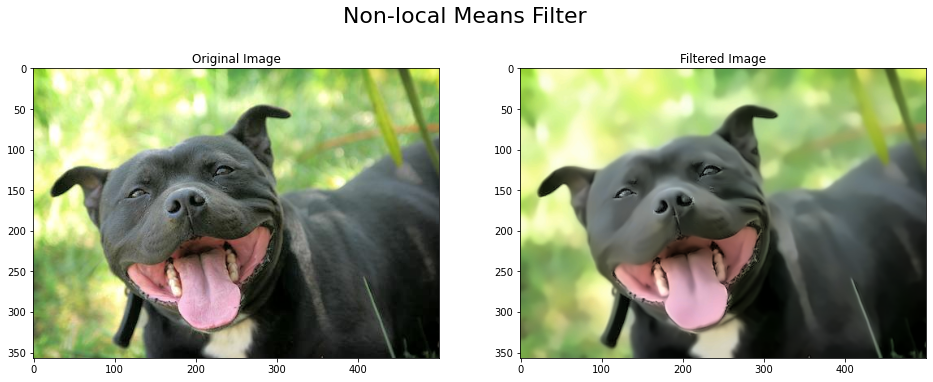

In [ ]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

# Augmentation des donnees 

In [ ]:
print('Nombre de photos total {}'.format(df_races.nb_photos.sum()))

Nombre de photos total 20580


Notre dataset comporte peu de données (20 580 images).

Un risque d over fitting peut arriver lors de l entrainement de notre modele.

Pour palier a ce probleme nous allons augmenter nos donnees !

Nous allons utiliser des images existante et leur appliquer une transformation aleatoire .

Nous realiserons cela grace a la classe <code>ImageDataGenerator</code> de keras concus pour cela

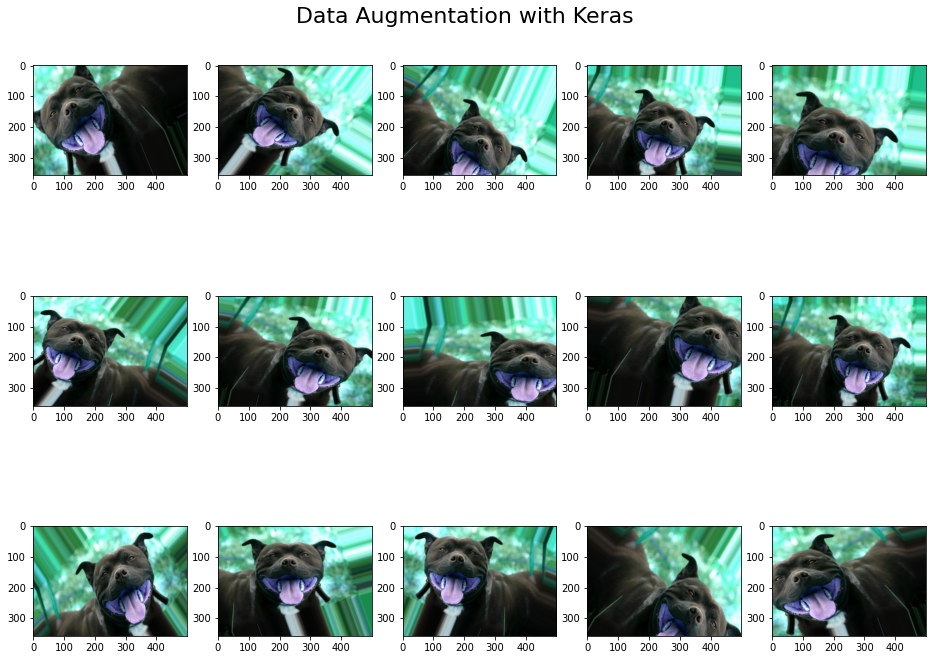

In [ ]:
#Initilize Data Generator Keras
# changer les parametres progressivement
#effectuer la data augmentation apres qq epochs

augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(test_img)
x = x.reshape((1,) + x.shape)
num_line = 5
num_col = 3
i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(num_col,num_line,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 15 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)

plt.show()

La méthode de Data Augmentation nous permet d'obtenir  différents images avec des zoom, des effets mirroir et des rotations différentes qui vont donc augmenter notre base d'images significativement .


**Nous allons selectionner aleatoirement 20 races de chiens pour nos tests, si ils sont concluant nous l etendrons a l ensemble des races**

In [ ]:
pre_selection =  [races_list[i] for i in np.random.randint(0, len(races_list), size=20)]
pre_selection

['Greater_Swiss_Mountain_dog',
 'komondor',
 'Tibetan_mastiff',
 'Doberman',
 'Irish_terrier',
 'Pekinese',
 'basset',
 'cocker_spaniel',
 'Norfolk_terrier',
 'Sealyham_terrier',
 'Rottweiler',
 'Kerry_blue_terrier',
 'black-and-tan_coonhound',
 'giant_schnauzer',
 'Australian_terrier',
 'Shih-Tzu',
 'Pembroke',
 'basset',
 'Blenheim_spaniel',
 'borzoi']

In [ ]:
def preprocessing(directories,images_directory, img_width, img_height):
#     fonction de preprocessing de nos images
#     applique les differents filtres vu ci dessus
    img_list=[]
    labels=[]
    for index, race in enumerate(directories):
        for image_name in tqdm(os.listdir(images_directory+"/"+race)):
            # Read image
            img = cv.imread(images_directory+"/"+race+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(race)
    
    return img_list, labels

In [ ]:
X, y = preprocessing(pre_selection, images_directory,  299, 299)

100%|██████████| 151/151 [01:01<00:00,  2.47it/s]


In [ ]:
#sauvegarde de nos datas
# import hickle as hkl
# data = {'X': X, 'y': y}
# hkl.dump(data,'data.hkl')
# import hickle as hkl
# data = hkl.load('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/data.hkl' )

In [ ]:
!pip install hickle

In [1]:
# chargement de nos donnees
import hickle as hkl
data = hkl.load('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/data.hkl' )
X = data['X']
y = data['y']

In [5]:
# Convert in numpy array
X = np.array(X)
y = np.array(y)

In [6]:
print("Number of images preprocessed : {}".format(len(y)))
print("Shape of images np.array : {}".format(X.shape))

Number of images preprocessed : 3402
Shape of images np.array : (3402, 299, 299, 3)


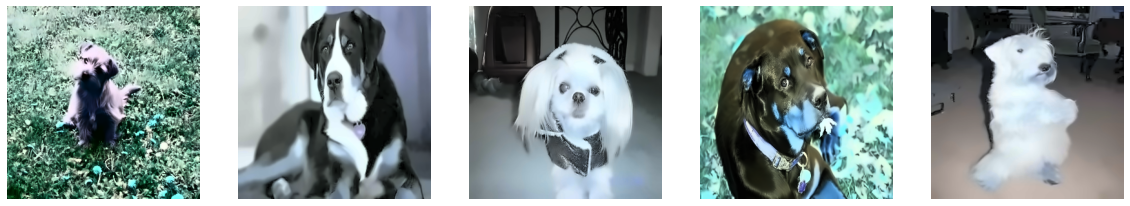

In [ ]:
utils.show_images_sample(X,num_sample=5)

**Resultats du preprocessing de nos images**

<a name='cnn'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
        Developpement de notre propre réseau CNN
        </h1>
    </div>
</div>

Nos images  ont été pré-traitées grâce notamment à l'égalisation, le débruitage et le redimensionnement. Nous avons créé des listes de tableaux Numpy regroupant les images sous format numériques.
et enfin nous allons mélanger les images.

Melange des datas dans X et y. Ce melange a pour objectif de réduire la variance et de s'assurer que les modèles ne soient pas sur-entraînés.

In [7]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(10)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

**labelEncoding de nos variables cibles**

In [8]:
# Encode y text data to numeric
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

In [ ]:
print(encoder.classes_)

['Australian_terrier' 'Blenheim_spaniel' 'Doberman'
 'Greater_Swiss_Mountain_dog' 'Irish_terrier' 'Kerry_blue_terrier'
 'Norfolk_terrier' 'Pekinese' 'Pembroke' 'Rottweiler' 'Sealyham_terrier'
 'Shih-Tzu' 'Tibetan_mastiff' 'basset' 'black-and-tan_coonhound' 'borzoi'
 'cocker_spaniel' 'giant_schnauzer' 'komondor']


modification du types X en float

In [9]:
# Change X type 
X = X.astype(np.float32)

Creation du train et test set pour l entrianement de nos modeles

Un set de validation sera créé egalement dans le générateur Keras.

In [10]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 8)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

Train set size =  2721
Test set size =  681


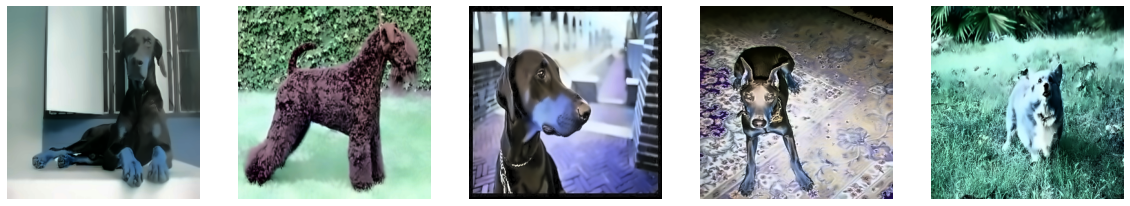

In [ ]:
utils.show_images_sample(x_train,num_sample=5)

Data augmentation de notre jeux de donnees

In [11]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

Ces générateurs seront  utilisés dans les pipeline  Keras

<a name='me'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
        Definition de nos metriques
        </h1>
    </div>
</div>


la metrique Accuracy est generalement utilser , nous allons ajouter le score f1 qui combine precision et recall

Ces metriques ne sont pas present sur keras , nous les definition ci dessous

In [13]:
# Metrics have been removed from Keras core. We need to calculate them manually
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Nous allons initialiser un premier modèle de réseau de neurones à convolution, avec 3 couches de convolution:

- **Couches de convolution** : Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Pour cela, on réalise un filtrage par convolution.
- **Couches de Pooling** : L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- **Couches de correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation ici nous utilisons la fonction d'activation Leaky ReLU qui aide le réseau à apprendre les limites de décision non linéaires

- **Couches Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

La fonction d'activation ReLU est beaucoup utilisée dans les architectures de réseaux de neurones et plus particulièrement dans les réseaux convolutifs, où elle s'est avérée plus efficace que la fonction sigmoïde logistique largement utilisée. Depuis 2017, cette fonction d'activation est la plus populaire pour les réseaux de neurones profonds. La fonction ReLU permet de seuiller l'activation à zéro. Cependant, pendant la formation, les unités ReLU peuvent "mourir". Cela peut se produire lorsqu'un gradient important traverse un neurone ReLU : cela peut entraîner la mise à jour des poids de telle sorte que le neurone ne s'activera plus jamais sur aucun point de données. Si cela se produit, le gradient traversant l'unité sera toujours nul à partir de ce point.

La dernière couche est une couche Dense qui a une fonction d'activation softmax avec le nombre de classes a classifier, qui est nécessaire pour ce problème de classification multi-classes.

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
batch_size = 64
epochs = 20
num_classes = 20

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(299,299,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 299, 299, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 150, 150, 64)      0         
                                                        

In [32]:
def plot_history_scores(dict_history,modele_name, first_score, second_score):
  fig = plt.figure(figsize=(25,10))
  # summarize history for accuracy
  plt.subplot(1, 2, 1)
  plt.plot(dict_history[first_score])
  plt.plot(dict_history['val_' + first_score],
            linestyle='--', color="red")
  plt.title(modele_name+' '+ first_score, fontsize=18)
  plt.ylabel(first_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(dict_history[second_score])
  plt.plot(dict_history['val_' + second_score],
            linestyle='--', color="red")
  plt.title(modele_name +' '+ second_score, fontsize=18)
  plt.ylabel(second_score)
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Une fois le modèle créé, nous le compilons a l'aide de l'optimiseur Adam, l'un des algorithmes d'optimisation les plus populaires.  Nous spécifions le type de perte qui est l'entropie croisée catégorielle qui est utilisée pour la classification multi-classes. Ainsi que nos metriques voulues

In [ ]:
# ajout de nos metriques a notre modele
#ici nous souhaiterons faire unc lassement multiclass 
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

 Entrainement du modèle CNN

Nous allons dans un premier temps entrainer notre modele uniquement sur nos donnees disponible, sans les augmenter par curiosite

In [ ]:
#test sans data generator
batch_size = 64
epochs = 50

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/50
43/43 [==============================] - 16s 124ms/step - loss: 430.6899 - accuracy: 0.0566 - f1_m: 1.1666 - val_loss: 123.8496 - val_accuracy: 0.1160 - val_f1_m: 1.0949
Epoch 2/50
43/43 [==============================] - 4s 88ms/step - loss: 14.4863 - accuracy: 0.0764 - f1_m: 1.7610 - val_loss: 233.0399 - val_accuracy: 0.0543 - val_f1_m: 1.0162
Epoch 3/50
43/43 [==============================] - 4s 89ms/step - loss: 11.4974 - accuracy: 0.0963 - f1_m: 1.8801 - val_loss: 228.8956 - val_accuracy: 0.0558 - val_f1_m: 1.0694
Epoch 4/50
43/43 [==============================] - 4s 89ms/step - loss: 11.6327 - accuracy: 0.1132 - f1_m: 2.1163 - val_loss: 119.1941 - val_accuracy: 0.0866 - val_f1_m: 1.1424
Epoch 5/50
43/43 [==============================] - 4s 89ms/step - loss: 7.0945 - accuracy: 0.1455 - f1_m: 2.4557 - val_loss: 182.6863 - val_accuracy: 0.0778 - val_f1_m: 1.0619
Epoch 6/50
43/43 [==============================] - 4s 89ms/step - loss: 9.6603 - accuracy: 0.1121 - f1_m: 2

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history', 'w'))
history_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history', 'r'))

In [ ]:
model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/model.h5')

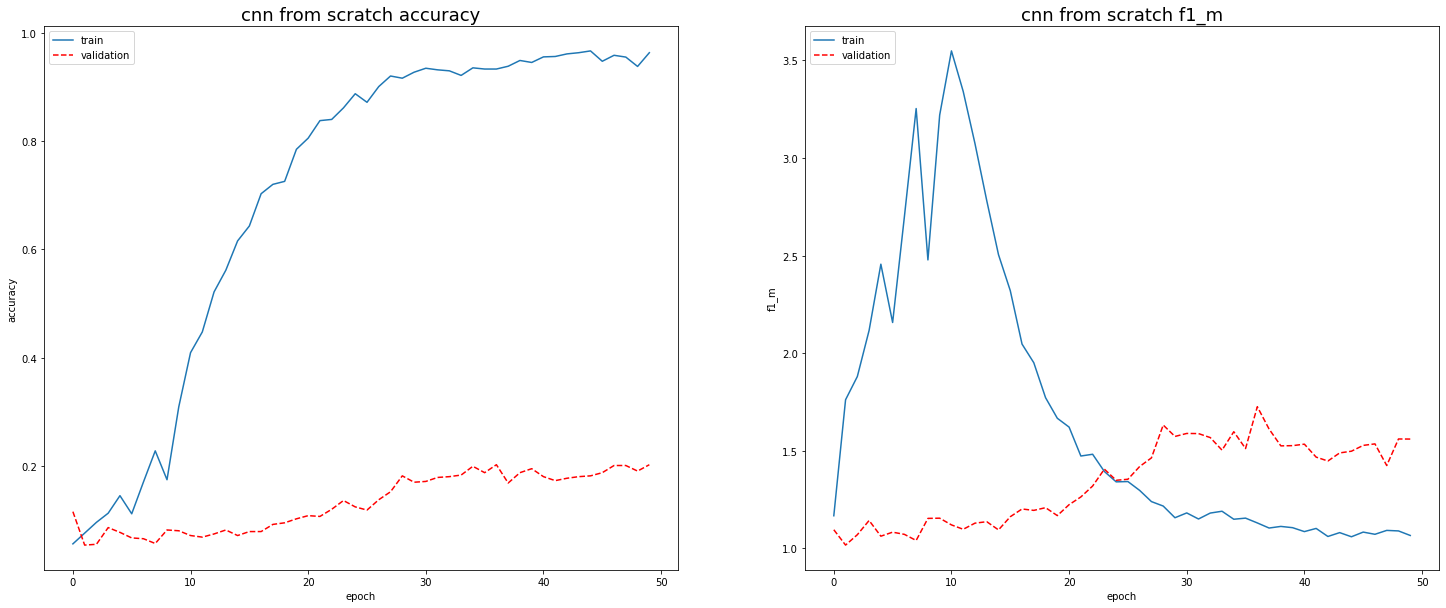

In [ ]:
#deuxieme modele sans image generator
plot_history_scores(
    dict_history = history_dict,
    modele_name= 'cnn from scratch', 
    first_score = "accuracy", 
    second_score = "f1_m")

In [15]:
model = load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/model.h5', custom_objects={"f1_m": f1_m})
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 165.88497924804688
Test accuracy: 0.230543315410614


On peut constater comme nous le supposions que notre modele est en over fitting...

Nous allons donc devoir augmenter notre jeux de donnees pour permettre au modele de s ameliorer

In [ ]:
#test premier neurone
batch_size = 64
epochs = 50

history_augmented = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    batch_size=batch_size,
    steps_per_epoch=len(x_train) / 32,
    epochs=epochs,
    verbose=2)

Epoch 1/50
85/85 - 34s - loss: 2.9791 - accuracy: 0.0852 - f1_m: 17.8416 - val_loss: 2.9384 - val_accuracy: 0.0993 - val_f1_m: 17.9029 - 34s/epoch - 399ms/step
Epoch 2/50
85/85 - 32s - loss: 2.9401 - accuracy: 0.0850 - f1_m: 18.3795 - val_loss: 2.9276 - val_accuracy: 0.0993 - val_f1_m: 17.7391 - 32s/epoch - 382ms/step
Epoch 3/50
85/85 - 32s - loss: 2.9104 - accuracy: 0.1032 - f1_m: 17.5076 - val_loss: 2.9026 - val_accuracy: 0.1011 - val_f1_m: 16.4957 - 32s/epoch - 379ms/step
Epoch 4/50
85/85 - 32s - loss: 2.8678 - accuracy: 0.1043 - f1_m: 16.4442 - val_loss: 2.8482 - val_accuracy: 0.0974 - val_f1_m: 15.0683 - 32s/epoch - 371ms/step
Epoch 5/50
85/85 - 32s - loss: 2.8078 - accuracy: 0.1185 - f1_m: 15.1289 - val_loss: 2.7558 - val_accuracy: 0.1121 - val_f1_m: 13.8876 - 32s/epoch - 377ms/step
Epoch 6/50
85/85 - 32s - loss: 2.7824 - accuracy: 0.1212 - f1_m: 15.0570 - val_loss: 2.7525 - val_accuracy: 0.1471 - val_f1_m: 14.1216 - 32s/epoch - 374ms/step
Epoch 7/50
85/85 - 32s - loss: 2.7459 - 

In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_augmented_dict = history_augmented.history
# Save it under the form of a json file
json.dump(history_augmented_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_augmented_dict', 'w'))
history_augmented_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_augmented_dict', 'r'))

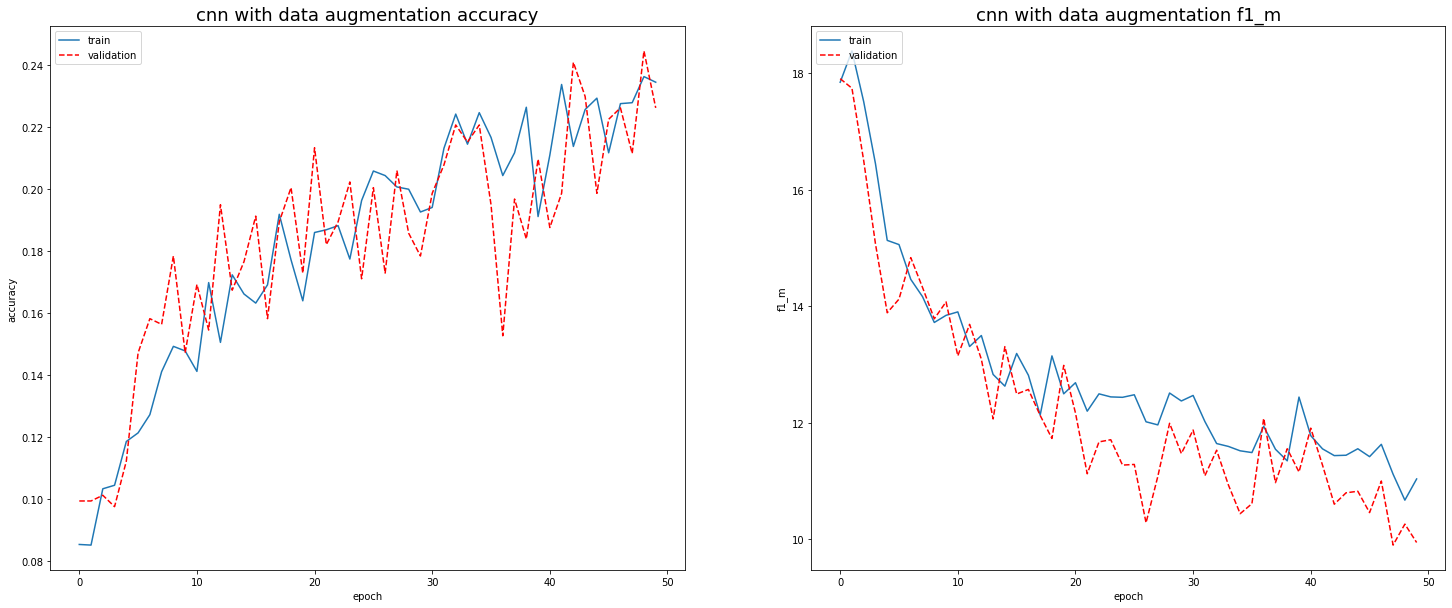

In [ ]:
#deuxieme modele
plot_history_scores(
    dict_history = history_augmented_dict, 
    modele_name= 'cnn with data augmentation', 
    first_score = "accuracy", 
    second_score = "f1_m")

Premiere bonne nouvelle , nous ne sommes plus en over fitting.

Mais les scores de nos metriques ne sont pas bonnes, l accuracy ne depasse pas 20% et le score F1 eleve

Evaluons le modele

In [ ]:
test_eval = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 225.77113342285156
Test accuracy: 0.17180617153644562


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_m', 'val_loss', 'val_accuracy', 'val_f1_m'])

In [ ]:
# modele prédictif (softmax)
prediction_model = keras.Sequential([model, keras.layers.Softmax()])
predict_proba = prediction_model.predict(x_test)
predictions = np.argmax(predict_proba, axis=1)

print(predictions[:20])
print(y_test[:20])

[ 3 13  3  2 13 15  1 13  8  3  1  8  1 10  3 10  8  3  3  1]
[ 3  1 14 13  6  8 13  1  8  0  7  8 11 10  9  3  1  7  2 13]


In [ ]:
# Make predictions
Y_pred = history_augmented.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

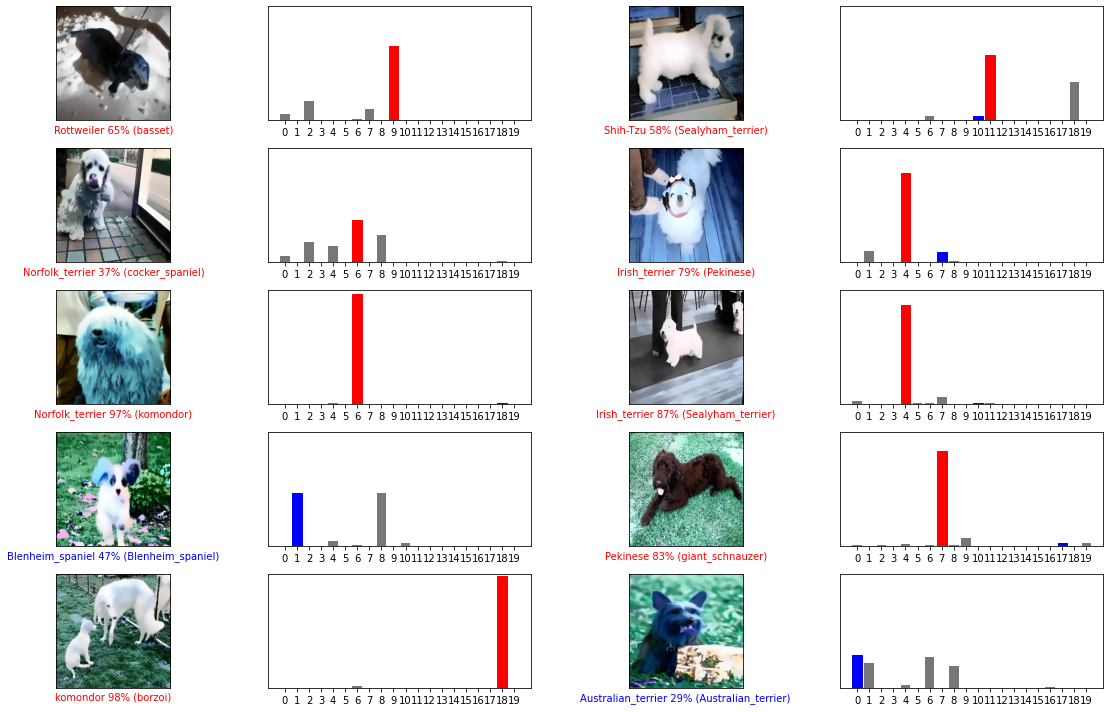

In [ ]:
class_names = encoder.classes_
num_class = len(class_names) +1 
utils.plot_predictions(x_test,y_test,Y_pred, class_names,num_class)

On peut remarquer malheuresement que la plupart de nos predictions sont mauvaises...


Nous allons donc tester des modèles pré-entrainés et vérifier si les performances comparées à notre baseline.

<a name='xc'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Transfert learning avec Xception
        </h1>
    </div>
</div>

L'intérêt de disposer de larges bases de données pour l'apprentissage est de pouvoir entraîner des réseaux sur des taches assez générales, pour ensuite réutiliser les poids ainsi appris dans d'autres applications. Cette opération est appelée transfer learning. Un réseau de neurones profond apprend des caractéristiques (features) de plus en plus abstraites (donc de haut niveau) à mesure que l'on progresse dans les couches.

Ainsi, un réseau de neurones pré-entraîné sur un large jeu de données possède des caractéristiques de bas niveau (apprises dans les premières couches) potentiellement transférables à de nombreuses tâches. Un avantage immédiat est le gain de temps. Un autre est le fait que les modèles obtenus sont plus robustes. En effet un réseau pré-entrainé sur une base de donnée complète a d'une part besoin de moins d'exemples (puisqu'il en a déjà vu beaucoup au premier entrainement), et a moins de risque de sur-apprendre des caractéristiques de bas niveau.


Architecture cnn Xception 

<img src="https://miro.medium.com/max/1200/1*459jKxLPM9R-Y_z0y8SXug.png" >

-La dimension de l’image analysée est réduite par les filtres 3x3 , en ajoute une étape de filtrage 1x1 en amont. De cette façon, la convolution de taille 1x1 effectue une opération de pooling sur les valeurs d’un pixel dans l’espace des dimensions de l’image.

- Xception remplace les modules Inception par des modules de convolutions séparables en profondeur (en anglais depthwise separable convolution) et ajoute des liaisons résiduelles. Ce type d’approche permet de considérablement réduire l’utilisation de ressources lors du calcul matriciel, sans modifier le nombre de paramètres.

<img src="https://www.researchgate.net/profile/Erik-Westphal/publication/350319854/figure/fig3/AS:1007308788203524@1617172538729/Xception-CNN-architecture-for-the-detection-and-classification-of-powder-bed-defects-at.png" >

- Xception est dérivé de l'architecture Inception. elle a pour but de réduire la consommation de ressources des CNN profonds. Il repose sur l'utilisation de blocs de traitement  

- Une opération de normalisation par lots est effectuée après chaque convolution et chaque bloc de convolution spatiale. Chaque bloc est numéroté, le premier étant la taille du noyau, le second étant le nombre de filtres dans le bloc particulier et le dernier étant la taille de l'étape de convolution.


recuperation du modele pré-entrainé de Keras mais sans les couches fully-connected. Nous allons le remplacer par notre propre classifier final.

In [18]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))
xception_model.summary()

83697664/83683744 [==============================] - 2s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

 **Entrainement du nouveau classifier sur Xception**

Notre jeu de données est petit et relativement similaire au dataset original. Si nous entrainons le réseau complet, nous risquons de rencontrer des problèmes d'over-fitting. Nous allons donc "geler" tous les layers de Xception et entrainer uniquement le classifier.


In [20]:
for layer in xception_model.layers:
    layer.trainable = False

la dernière couche importée est une couche GlobalAveragePooling2D

Nous allons ajouter une couche fully connected, un DropOut et le classifier dans un nouveau modèle

In [22]:
# Add new fully-connected layers
# print(encoder.classes_)
output = xception_model.output
output = Dense(128, activation='relu')(output)
output = Dropout(0.2)(output)
# Output : new classifier
predictions = Dense(20, activation='softmax')(output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])
my_xcept_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

modification des générateurs  recommandé par Keras :

In [23]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [24]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)

Epoch 1/50
85/85 - 174s - loss: 1.7706 - accuracy: 0.4857 - f1_m: 8.1846 - val_loss: 1.0634 - val_accuracy: 0.7096 - val_f1_m: 3.8866 - 174s/epoch - 2s/step
Epoch 2/50
85/85 - 170s - loss: 0.9886 - accuracy: 0.7157 - f1_m: 3.4008 - val_loss: 0.8819 - val_accuracy: 0.7335 - val_f1_m: 2.9586 - 170s/epoch - 2s/step
Epoch 3/50
85/85 - 170s - loss: 0.8009 - accuracy: 0.7517 - f1_m: 2.8006 - val_loss: 0.7938 - val_accuracy: 0.7408 - val_f1_m: 2.6252 - 170s/epoch - 2s/step
Epoch 4/50
85/85 - 168s - loss: 0.7222 - accuracy: 0.7803 - f1_m: 2.4193 - val_loss: 0.8018 - val_accuracy: 0.7665 - val_f1_m: 2.3435 - 168s/epoch - 2s/step
Epoch 5/50
85/85 - 168s - loss: 0.6803 - accuracy: 0.7847 - f1_m: 2.4230 - val_loss: 0.7800 - val_accuracy: 0.7665 - val_f1_m: 2.2351 - 168s/epoch - 2s/step
Epoch 6/50
85/85 - 169s - loss: 0.6227 - accuracy: 0.8119 - f1_m: 2.1611 - val_loss: 0.8089 - val_accuracy: 0.7629 - val_f1_m: 2.2916 - 169s/epoch - 2s/step
Epoch 7/50
85/85 - 169s - loss: 0.6611 - accuracy: 0.7884 

In [25]:
my_xcept_model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_xcept_model_2.h5')

In [29]:
xception_eval = my_xcept_model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

43/43 [==============================] - 58s 1s/step - loss: 0.3686 - accuracy: 0.8869 - f1_m: 1.3293
Test Loss: 0.369
Test Accuracy: 0.887
Test F1 score: 1.329


In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_xcept_dict = history_xcept.history
# Save it under the form of a json file
json.dump(history_xcept_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_xcept_dict', 'w'))
history_xcept_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_xcept_dict', 'r'))

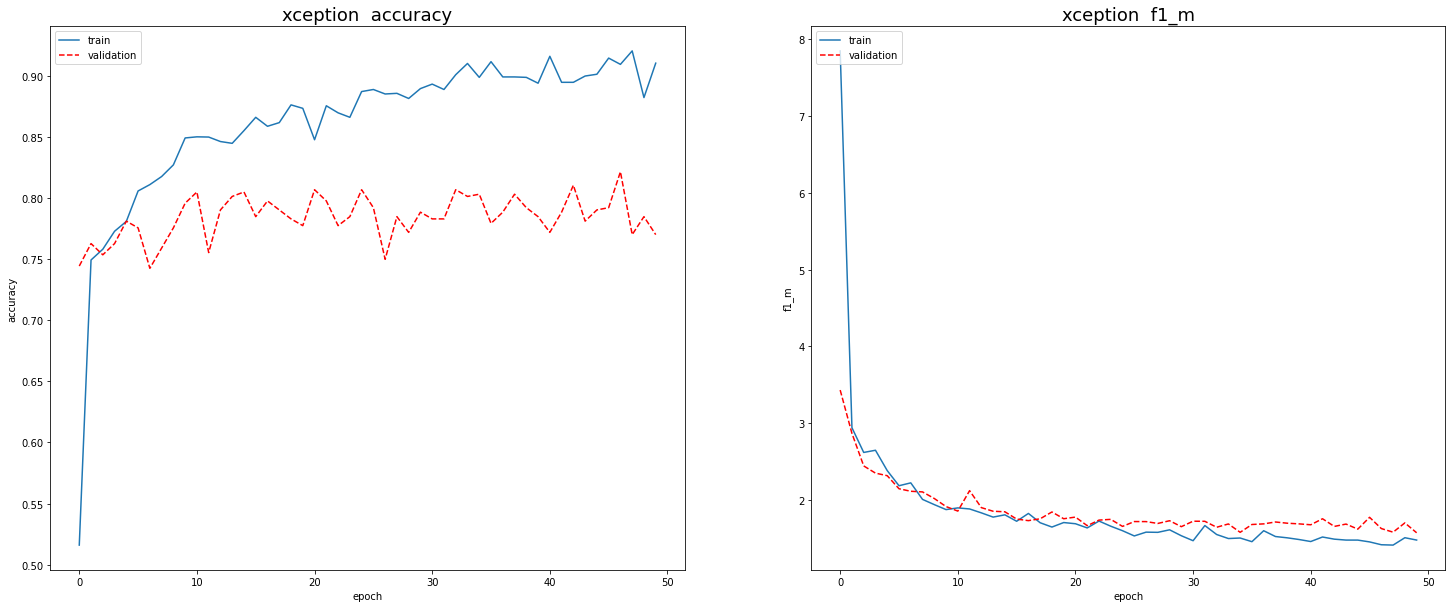

In [ ]:
plot_history_scores(
    dict_history = history_xcept.history, 
    modele_name= 'xception ', 
    first_score = "accuracy", 
    second_score = "f1_m")

- On voit bien ici que les métriques du modèle Xception sont bien meilleures que le modèle "from scratch" quand les couches profondes ne sont pas entrainées. 
- Le modèle apprend plus vite et l'accuracy augmente rapidement et la perte diminue.

Comparaisons de nos modeles

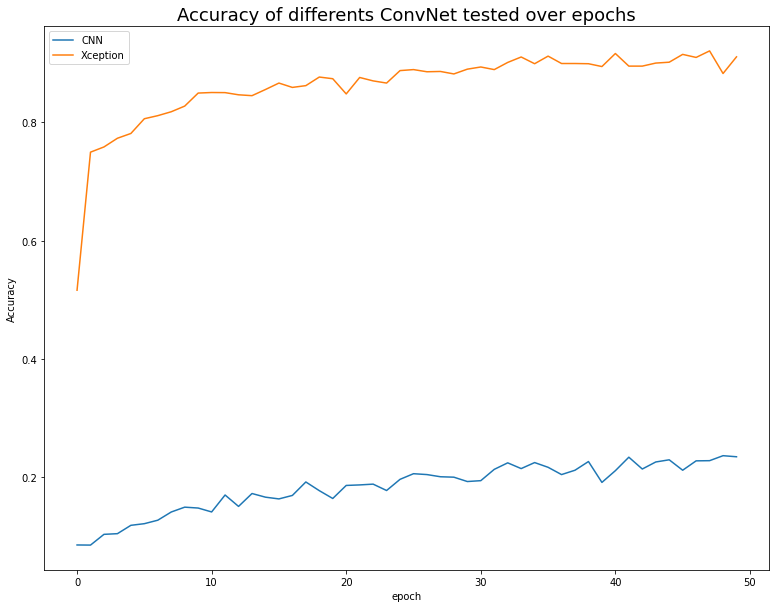

In [ ]:
plt.figure(figsize=(13,10))
plt.plot(history_augmented.history['accuracy'],
          label='CNN')
plt.plot(history_xcept.history['accuracy'],
          label='Xception')
plt.title('Accuracy of differents ConvNet tested over epochs',
          fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
print("Mean validation accuracy: {:.2f}"\
      .format(np.mean(history_xcept.history['val_accuracy'])))
print("Mean validation F1 score: {:.2f}"\
      .format(np.mean(history_xcept.history['val_f1_m'])))

Mean validation accuracy: 0.78
Mean validation F1 score: 1.86


<a name='res'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Transfert learning avec ResNet50
        </h1>
    </div>
</div>


<img src="https://iq.opengenus.org/content/images/2020/03/Screenshot-from-2020-03-20-15-49-54.png" >
Architecture 

- Une convolution avec une taille de noyau de 7 * 7 et 64 noyaux différents tous avec une foulée de taille 2 nous donnant 1 couche .

- Ensuite, nous voyons la mise en commun maximale avec également une taille de foulée de 2.Dans la convolution suivante, il y a un noyau 1 * 1,64 suivi d'un noyau 3 * 3,64 et enfin d'un noyau 1 * 1,256. Ces trois couches sont répétées au total 3 fois, ce qui nous donne 9 couches dans cette étape.

- Ensuite, nous voyons un noyau de 1 * 1 128 après cela un noyau de 3 * 3 128 et enfin un noyau de 1 * 1 512 cette étape a été répétée 4 fois nous donnant ainsi 12 couches dans cette étape.

- Après cela, il y a un noyau de 1 * 1 256 et deux autres noyaux avec 3 * 3 256 et 1 * 1 1024 et ceci est répété 6 fois nous donnant un total de 18 couches .

- Et puis encore un noyau 1 * 1 512 avec deux autres de 3 * 3 512 et 1 * 1 2048 et cela a été répété 3 fois nous donnant un total de 9 couches .

- Après cela, nous faisons un pool moyen et le terminons avec une couche entièrement connectée contenant 1000 nœuds et à la fin une fonction softmax, ce qui nous donne 1 couche .


<img src="https://www.researchgate.net/publication/349717475/figure/fig4/AS:996933933993986@1614698980245/The-architecture-of-ResNet-50-model.ppm" >







Chargeons le modèle de base pré-entrainé Resnet de Keras mais sans les couches fully-connected. Nous allons le remplacer par notre propre classifier final.

In [ ]:
K.clear_session()
num_class = 20
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
  weights='imagenet',
  include_top=False, 
  pooling='avg',
  input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
  rn_layer.trainable = False
  
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_class, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                      outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy", f1_m])

# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest',
  validation_split=0.2,
  preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
  preprocessing_function=tf.keras.applications.resnet.preprocess_input)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
85/85 - 38s - loss: 2.5077 - accuracy: 0.2454 - f1_m: 11.1017 - val_loss: 1.8583 - val_accuracy: 0.4632 - val_f1_m: 9.8168 - 38s/epoch - 445ms/step
Epoch 2/20
85/85 - 33s - loss: 1.6243 - accuracy: 0.5018 - f1_m: 6.9481 - val_loss: 1.4176 - val_accuracy: 0.5496 - val_f1_m: 5.7568 - 33s/epoch - 387ms/step
Epoch 3/20
85/85 - 33s - loss: 1.3074 - accuracy: 0.5988 - f1_m: 4.7322 - val_loss: 1.1403 - val_accuracy: 0.6305 - val_f1_m: 4.8098 - 33s/epoch - 383ms/step
Epoch 4/20
85/85 - 33s - loss: 1.1693 - accuracy: 0.6301 - f1_m: 4.1753 - val_loss: 1.1023 - val_accuracy: 0.6305 - val_f1_m: 3.5839 - 33s/epoch - 387ms/step
Epoch 5/20
85/85 - 33s - loss: 1.1176 - accuracy: 0.6392 - f1_m: 3.8886 - val_loss: 1.0537 - val_accuracy: 0.6820 - val_f1_m: 3.4197 - 33s/epoch - 389ms/step
Epoch 6/20
85/85 - 33s - loss: 1.0102 - accuracy: 0.6554 - f1_m: 3.4287 - val_loss: 0.9749 - val_accuracy: 0.6820 - val_f1_m: 3.2420 - 33s/epoch - 383ms/step
Epoch 7/20
85/85 - 33s - loss: 0.9281 - accuracy: 0

In [ ]:
my_resnet_model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_resnet_model.h5')

In [40]:
test_eval = my_resnet_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7442795634269714
Test accuracy: 0.7621145248413086


In [37]:
test = load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_resnet_model.h5', custom_objects={"f1_m": f1_m})
test_eval = test.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.7442795634269714
Test accuracy: 0.7621145248413086


In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_resnet_dict = history_resnet.history
# Save it under the form of a json file
json.dump(history_resnet_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_resnet_dict', 'w'))
history_resnet_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_resnet_dict', 'r'))

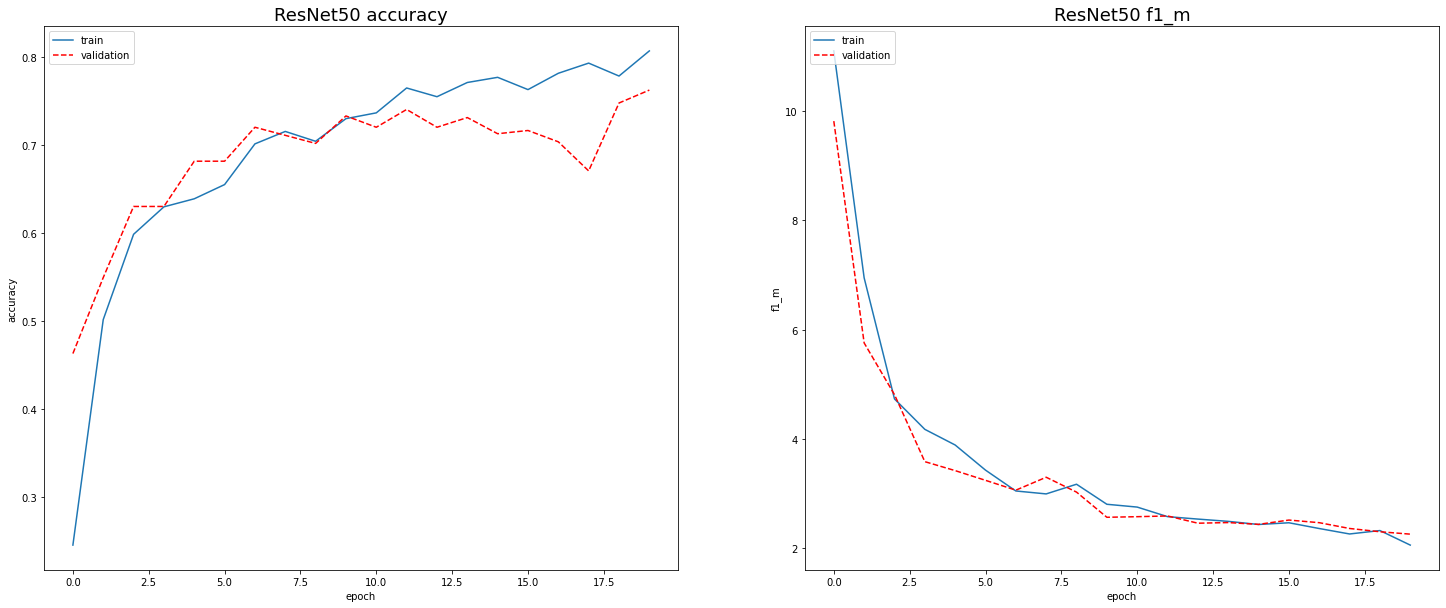

In [ ]:
plot_history_scores(
    dict_history = history_resnet_dict, 
    modele_name = 'ResNet50',
    first_score = "accuracy", 
    second_score = "f1_m")

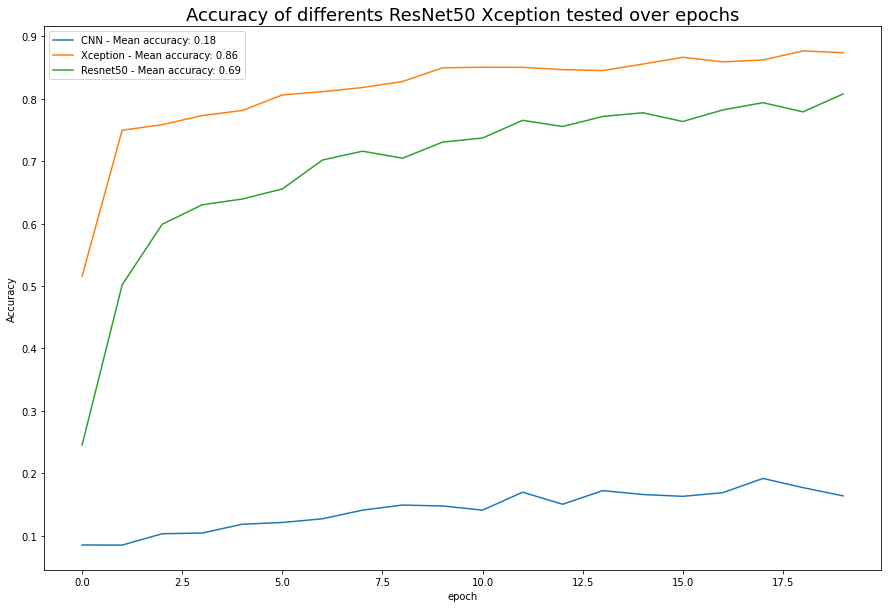

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history_augmented_dict['accuracy'][0:20],
          label='CNN - Mean accuracy: {:.2f}'.format(
              np.mean(history_augmented_dict['accuracy'])))
plt.plot(history_xcept_dict['accuracy'][0:20],
          label='Xception - Mean accuracy: {:.2f}'.format(
              np.mean(history_xcept_dict['accuracy'])))
plt.plot(history_resnet_dict['accuracy'][0:20],
          label='Resnet50 - Mean accuracy: {:.2f}'.format(
              np.mean(history_resnet_dict['accuracy'])))
plt.title('Accuracy of differents ResNet50 Xception tested over epochs',
          fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

le modèle **Xception** offre les meilleurs résultats. Nous choisissons  ce modèle pour la suite.

testons les predictions du modele Xception


In [ ]:
# Make predictions
Y_pred = history_xcept.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

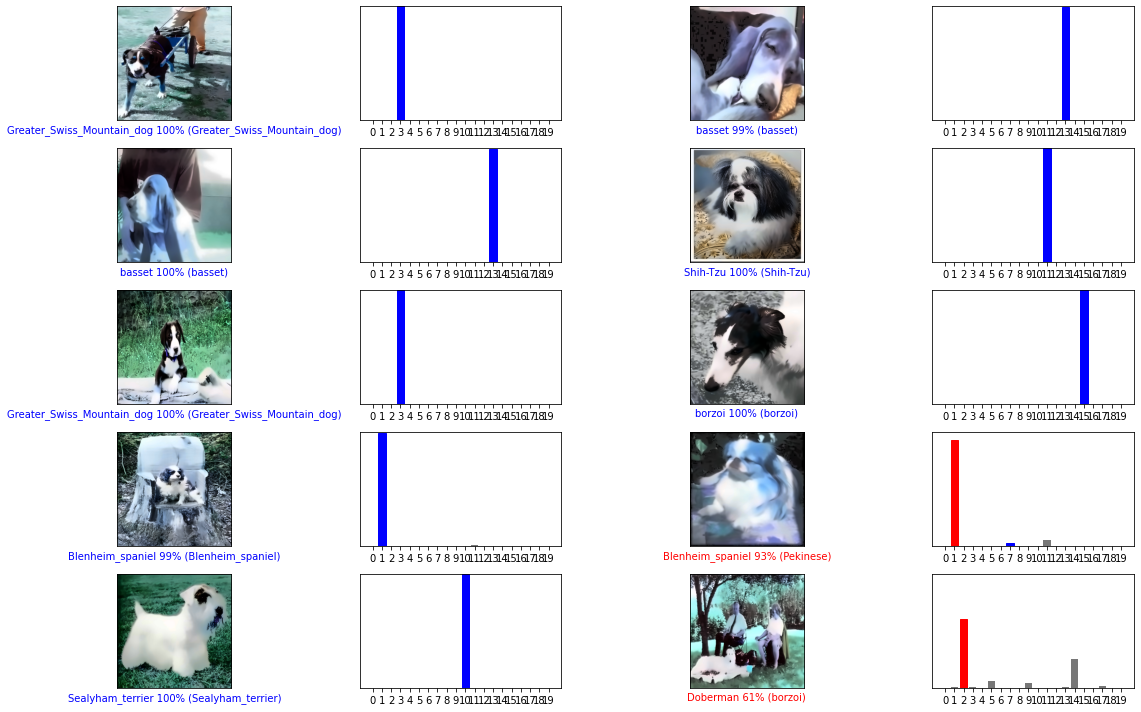

In [ ]:
class_names = encoder.classes_
num_class = len(class_names) +1 
utils.plot_predictions(x_test,y_test,Y_pred, class_names,num_class)

nos resultats sont bon mais pas parfait !


<a name='op'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Optimisation du modele Xception avec Kerastuner
        </h1>
    </div>
</div>

KerasTuner est un peu l equivalent du gridSerachCv de scikit , il va nous servir a ameliorer les parametres de la couche ajoute a notre modele Xception afin de l optimiser

In [ ]:
num_classes = 20


def build_model(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299, 299, 3))

    for layer in xception_model.layers:
        layer.trainable = False

    base_output = xception_model.output

    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units,
                        activation='relu')(base_output)

    base_output = Dropout(0.2)(base_output)

    # Output : new classifier
    base_output = Dense(num_classes, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                           outputs=base_output)

    # Tune learning rate with hyperparameter
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4, 1e-5])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])

    return my_xcept_model

Optimisation de nos parametre grace a kt.RandomSearch

Definition d un callback early stopping sur l accuracy

In [ ]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    build_model, 
    objective='val_accuracy',
    max_trials=5)

# early stopping if accuracy won t improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=4)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
Best learning rate : {best_hyperparameters.get('learning_rate')}.\n
Best Dense units : {best_hyperparameters.get('dense_units')}.""")

Trial 5 Complete [00h 08m 20s]
val_accuracy: 0.7922794222831726

Best val_accuracy So Far: 0.810661792755127
Total elapsed time: 00h 39m 54s
INFO:tensorflow:Oracle triggered exit

Best learning rate : 0.001.

Best Dense units : 224.


In [ ]:
import hickle as hkl
# best_hyperparameters_test = {'best_hyperparameters': best_hyperparameters}
hkl.dump(best_hyperparameters,'/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/best_hyperparameters.hkl')

best_hyperparameters2 = hkl.load('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/best_hyperparameters.hkl' )

/usr/local/lib/python3.7/dist-packages/hickle/loaders/load_builtins.py:110: SerializedWarning: 'HyperParameters' type not understood, data has been serialized
  % (py_obj.__class__.__name__, reason_str), SerializedWarning)


Les meilleurs paramètres sont trouvés, on  ré-entraine le modèle grâce au tuner, sur 30 époques avant de le sauvegarder pour les prochaines améliorations (fine-tuning) 

In [ ]:
hypermodel = tuner.hypermodel.build(best_hyperparameters2)
history_hypermodel = hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'), 
    epochs=30,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)
print("Model saved")

Epoch 1/30
137/137 - 52s - loss: 1.3751 - accuracy: 0.6031 - f1_m: 5.7021 - val_loss: 0.8275 - val_accuracy: 0.7445 - val_f1_m: 2.9106 - 52s/epoch - 380ms/step
Epoch 2/30
137/137 - 48s - loss: 0.7898 - accuracy: 0.7437 - f1_m: 2.5854 - val_loss: 0.6971 - val_accuracy: 0.7721 - val_f1_m: 2.2423 - 48s/epoch - 350ms/step
Epoch 3/30
137/137 - 48s - loss: 0.6461 - accuracy: 0.7887 - f1_m: 2.1875 - val_loss: 0.7299 - val_accuracy: 0.7610 - val_f1_m: 2.3655 - 48s/epoch - 348ms/step
Epoch 4/30
137/137 - 48s - loss: 0.5928 - accuracy: 0.8167 - f1_m: 2.1109 - val_loss: 0.6873 - val_accuracy: 0.7849 - val_f1_m: 2.0055 - 48s/epoch - 352ms/step
Epoch 5/30
137/137 - 48s - loss: 0.5673 - accuracy: 0.8199 - f1_m: 2.0240 - val_loss: 0.7373 - val_accuracy: 0.7849 - val_f1_m: 2.0320 - 48s/epoch - 349ms/step
Epoch 6/30
137/137 - 48s - loss: 0.4955 - accuracy: 0.8447 - f1_m: 1.8666 - val_loss: 0.6469 - val_accuracy: 0.7960 - val_f1_m: 1.8547 - 48s/epoch - 352ms/step
Epoch 7/30
137/137 - 48s - loss: 0.5123 

In [ ]:
hypermodel.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/xception_hypermodel.h5')

In [ ]:
# Model evaluation on test set
hypermodel_evaluate = hypermodel.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print('Test Loss: {:.3f}'.format(hypermodel_evaluate[0]))
print('Test Accuracy: {:.3f}'.format(hypermodel_evaluate[1]))
print('Test F1 score: {:.3f}'.format(hypermodel_evaluate[2]))

43/43 [==============================] - 2s 42ms/step - loss: 0.5182 - accuracy: 0.8590 - f1_m: 1.3004
Test Loss: 0.518
Test Accuracy: 0.859
Test F1 score: 1.300


In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
history_hypermodel_dict = history_hypermodel.history
# Save it under the form of a json file
json.dump(history_hypermodel_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_hypermodel_dict', 'w'))
history_hypermodel_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/history_hypermodel_dict', 'r'))

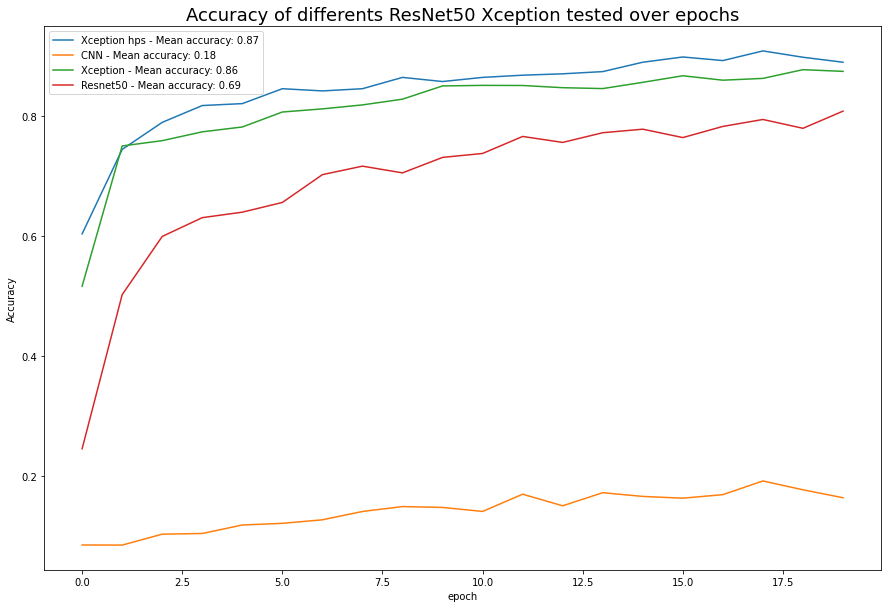

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history_hypermodel_dict['accuracy'][0:20],
          label='Xception hps - Mean accuracy: {:.2f}'.format(
              np.mean(history_hypermodel_dict['accuracy'])))
plt.plot(history_augmented_dict['accuracy'][0:20],
          label='CNN - Mean accuracy: {:.2f}'.format(
              np.mean(history_augmented_dict['accuracy'])))
plt.plot(history_xcept_dict['accuracy'][0:20],
          label='Xception - Mean accuracy: {:.2f}'.format(
              np.mean(history_xcept_dict['accuracy'])))
plt.plot(history_resnet_dict['accuracy'][0:20],
          label='Resnet50 - Mean accuracy: {:.2f}'.format(
              np.mean(history_resnet_dict['accuracy'])))
plt.title('Accuracy of differents ResNet50 Xception tested over epochs',
          fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()




<a name='fi'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Xception fine tuning
        </h1>
    </div>
</div>



Comme nous l'avons vu dans le schéma de l'architecture Xception, ce modèle dispose de 3 blocs : le flux, d'entrée, le flux moyen et le flux de sortie. Nous allons ré-entrainer le dernier bloc sur le modèle sauvegardé dont les paramètres ont été améliorés :


In [ ]:
def build_model_tune(nb_layers):
    # Load the pre trained model
    hypermodel = load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/xception_hypermodel.h5', custom_objects={"f1_m": f1_m})
    
    # re train the last layers
    for i, layer in enumerate(hypermodel.layers):
      layer.trainable = False if i < nb_layers else True 
            
    # Compile model
    hypermodel.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return hypermodel

In [ ]:
len(my_tuned_xcept_model.layers)

136

In [ ]:

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the  110 first layers only 26
my_tuned_xcept_model = build_model_tune(110)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'), 
    epochs=20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

Epoch 1/20
137/137 - 53s - loss: 1.0084 - accuracy: 0.7042 - f1_m: 2.9248 - val_loss: 1.4592 - val_accuracy: 0.6489 - val_f1_m: 1.7863 - 53s/epoch - 390ms/step
Epoch 2/20
137/137 - 49s - loss: 0.7172 - accuracy: 0.7763 - f1_m: 2.0721 - val_loss: 1.0241 - val_accuracy: 0.7298 - val_f1_m: 1.6447 - 49s/epoch - 357ms/step
Epoch 3/20
137/137 - 49s - loss: 0.4986 - accuracy: 0.8535 - f1_m: 1.6722 - val_loss: 1.2796 - val_accuracy: 0.6710 - val_f1_m: 1.6391 - 49s/epoch - 361ms/step
Epoch 4/20
137/137 - 49s - loss: 0.4637 - accuracy: 0.8627 - f1_m: 1.5976 - val_loss: 1.2404 - val_accuracy: 0.7096 - val_f1_m: 1.5377 - 49s/epoch - 358ms/step
Epoch 5/20
137/137 - 49s - loss: 0.3388 - accuracy: 0.8976 - f1_m: 1.4724 - val_loss: 1.0681 - val_accuracy: 0.7721 - val_f1_m: 1.4374 - 49s/epoch - 359ms/step
Epoch 6/20
137/137 - 49s - loss: 0.2990 - accuracy: 0.9068 - f1_m: 1.3292 - val_loss: 1.3357 - val_accuracy: 0.7059 - val_f1_m: 1.6613 - 49s/epoch - 359ms/step
Epoch 7/20
137/137 - 50s - loss: 0.2767 

In [ ]:
my_tuned_xcept_model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_tuned_xcept_model.h5')

In [55]:
# Model evaluation on test set
my_tuned_xcept_model= load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_tuned_xcept_model.h5', custom_objects={"f1_m": f1_m})
tunemodel_evaluate = my_tuned_xcept_model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print('Test Loss: {:.3f}'.format(tunemodel_evaluate[0]))
print('Test Accuracy: {:.3f}'.format(tunemodel_evaluate[1]))
print('Test F1 score: {:.3f}'.format(tunemodel_evaluate[2]))

43/43 [==============================] - 62s 1s/step - loss: 0.2536 - accuracy: 0.9413 - f1_m: 1.1189
Test Loss: 0.254
Test Accuracy: 0.941
Test F1 score: 1.119


In [ ]:
import json
# Get the dictionary containing each metric and the loss for each epoch
fine_tuned_history_dict = fine_tuned_history.history
# Save it under the form of a json file
json.dump(fine_tuned_history_dict, open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/fine_tuned_history_dict', 'w'))
fine_tuned_history_dict = json.load(open('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/fine_tuned_history_dict', 'r'))

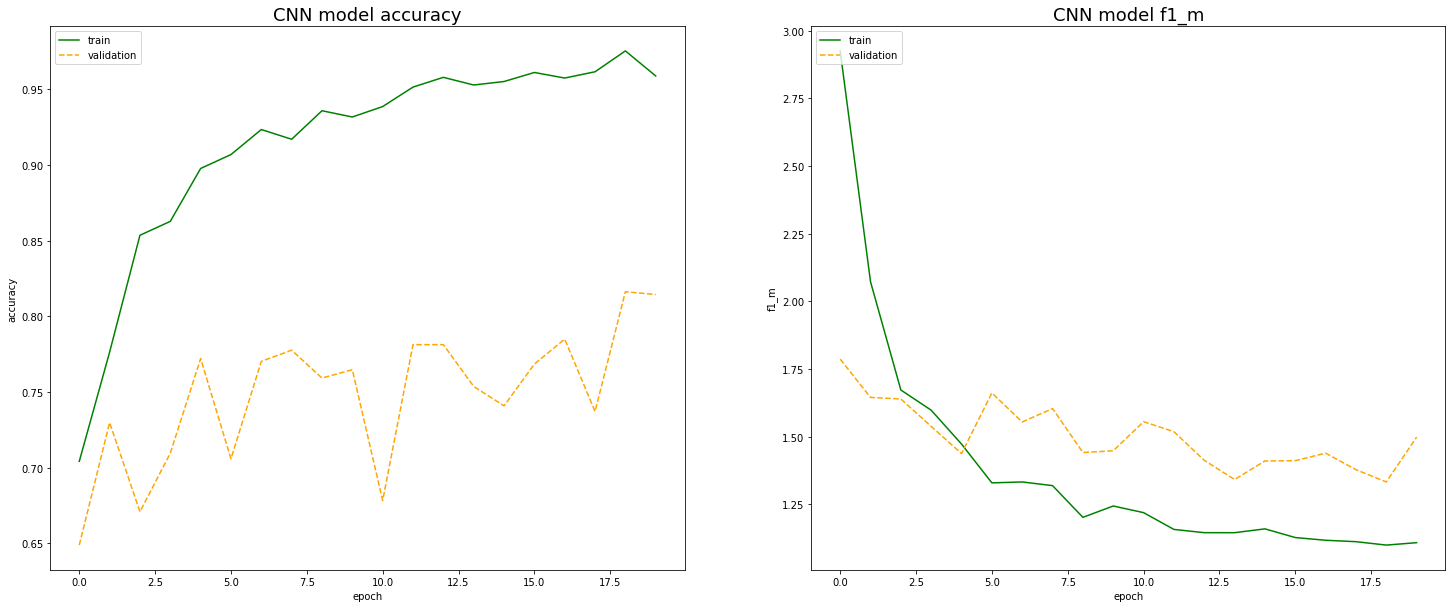

In [ ]:
plot_history_scores(
    dict_history = fine_tuned_history_dict, 
    first_score = "accuracy", 
    second_score = "f1_m")

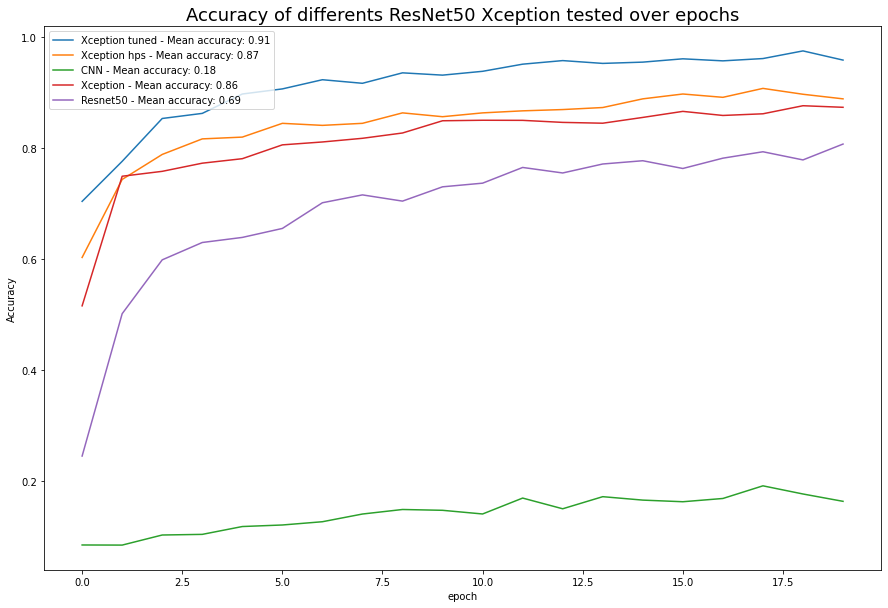

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(fine_tuned_history_dict['accuracy'][0:20],
          label='Xception tuned - Mean accuracy: {:.2f}'.format(
              np.mean(fine_tuned_history_dict['accuracy'])))
plt.plot(history_hypermodel_dict['accuracy'][0:20],
          label='Xception hps - Mean accuracy: {:.2f}'.format(
              np.mean(history_hypermodel_dict['accuracy'])))
plt.plot(history_augmented_dict['accuracy'][0:20],
          label='CNN - Mean accuracy: {:.2f}'.format(
              np.mean(history_augmented_dict['accuracy'])))
plt.plot(history_xcept_dict['accuracy'][0:20],
          label='Xception - Mean accuracy: {:.2f}'.format(
              np.mean(history_xcept_dict['accuracy'])))
plt.plot(history_resnet_dict['accuracy'][0:20],
          label='Resnet50 - Mean accuracy: {:.2f}'.format(
              np.mean(history_resnet_dict['accuracy'])))
plt.title('Accuracy of differents ResNet50 Xception tested over epochs',
          fontsize=18)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Le meilleur modèle testé est le modèle Xception pré-entrainé avec fine-tuning. Nous allons donc selectionner ce modele pour la generalisation sur tous le dataset. 

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
fine_tuned_history.model.save('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_tuned_xcept_model.h5')

In [42]:
fine_tuned_history_model= load_model('/content/ShardDrives/MyDrive/Stanford_Dogs_Dataset/my_tuned_xcept_model.h5', custom_objects={"f1_m": f1_m})

In [43]:
xception_eval2 = fine_tuned_history_model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print('Test Loss: {:.3f}'.format(xception_eval2[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval2[1]))
print('Test F1 score: {:.3f}'.format(xception_eval2[2]))

43/43 [==============================] - 66s 2s/step - loss: 0.2536 - accuracy: 0.9413 - f1_m: 1.1189
Test Loss: 0.254
Test Accuracy: 0.941
Test F1 score: 1.119


<a name='resu'></a>
<div class="bg-primary text-lg-left text-white">
    <div >
        <h1 class="text-center" style="padding: 10px 0 10px 0;">
         Resultats
        </h1>
    </div>
</div>

In [46]:
# Make predictions
Y_pred = fine_tuned_history_model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

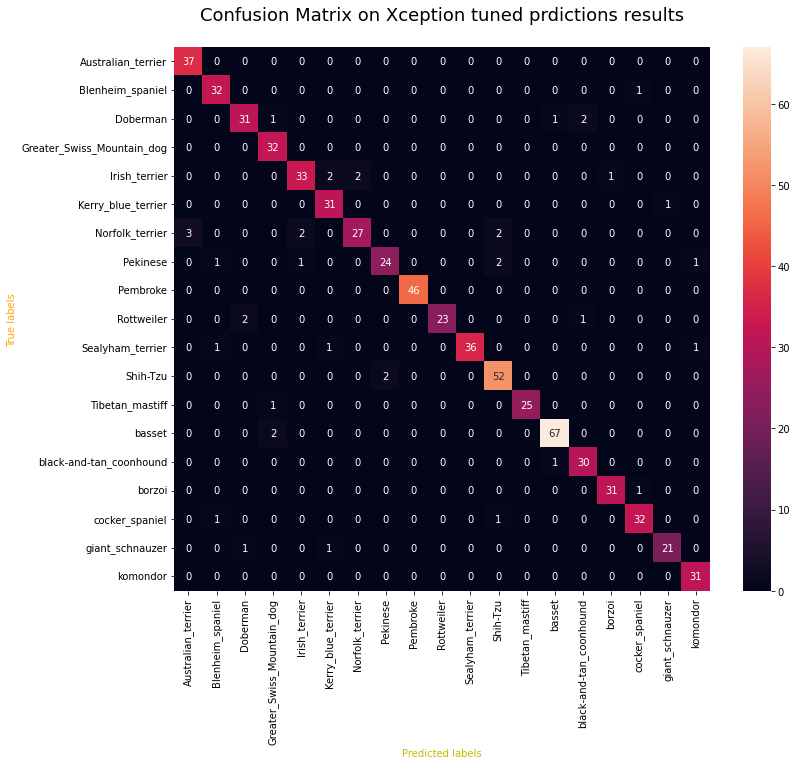

In [48]:
fig = plt.figure(figsize=(12,10))
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="y")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception tuned prdictions results\n",
          fontsize=18)
plt.show()

In [47]:
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(encoder.classes_))))

                            precision    recall  f1-score   support

        Australian_terrier       0.93      1.00      0.96        37
          Blenheim_spaniel       0.91      0.97      0.94        33
                  Doberman       0.91      0.89      0.90        35
Greater_Swiss_Mountain_dog       0.89      1.00      0.94        32
             Irish_terrier       0.92      0.87      0.89        38
        Kerry_blue_terrier       0.89      0.97      0.93        32
           Norfolk_terrier       0.93      0.79      0.86        34
                  Pekinese       0.92      0.83      0.87        29
                  Pembroke       1.00      1.00      1.00        46
                Rottweiler       1.00      0.88      0.94        26
          Sealyham_terrier       1.00      0.92      0.96        39
                  Shih-Tzu       0.91      0.96      0.94        54
           Tibetan_mastiff       1.00      0.96      0.98        26
                    basset       0.97      0.97

- La matrice de confusion et le rapport de classification nous indiquent que les résultats sont satisfaisants.
- l'Accuracy globale sur le jeu de test est de 0.94 et la matrice présente bien les couples predict / true majoritaires en diagonale

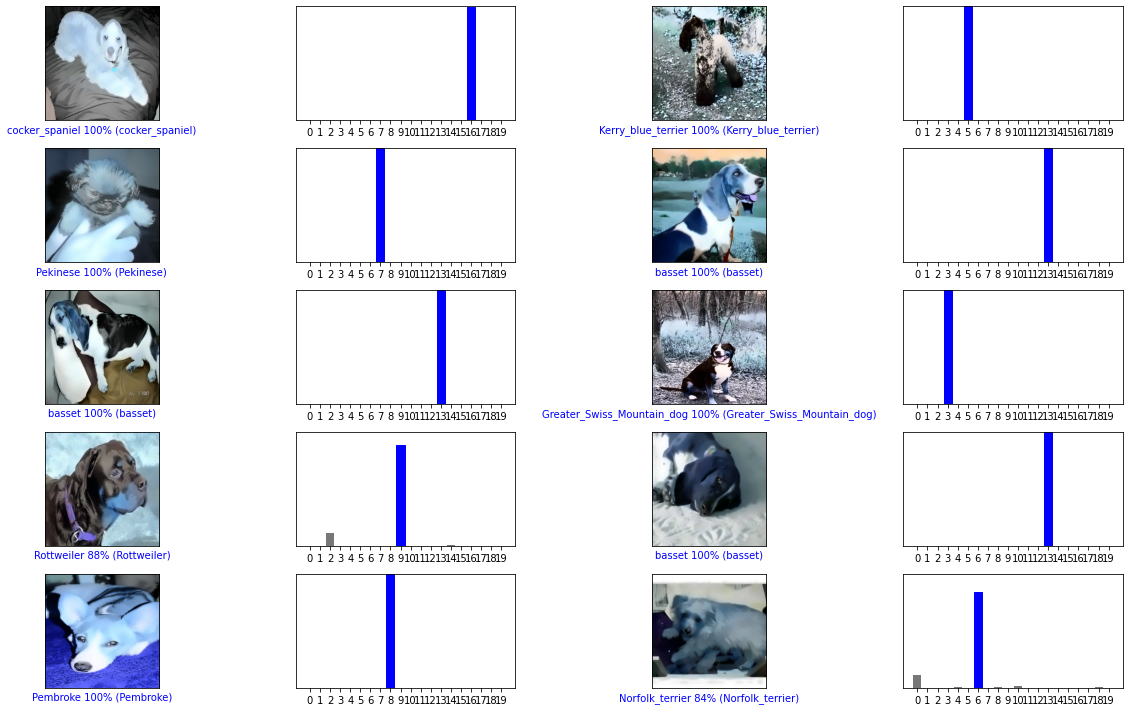

In [52]:
class_names = encoder.classes_
num_class = len(class_names) +1 
utils.plot_predictions(x_test,y_test,Y_pred, class_names,num_class)

**les prédictions sont bonnes dans la plupart des cas**